In [1]:
# To be able to use the quantools, due to my crap path names have to add to sys path
import sys
sys.path.insert(0, '/home/adam/Dropbox/2-creations/2-crafts/7-buidl/0-utils/quant_tools/code')

# Import packages
from joblib import Parallel, delayed
from datetime import timedelta
import pandas_datareader as pdr
import matplotlib.pyplot as plt
from typing import Dict, List
from tools import QuantTools
from scipy.stats import norm
import scipy.stats as stats
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib
import datetime
import pickle
import random

# set color map
viridis = matplotlib.colormaps['viridis']

In [2]:
def importYahoo(ticker: str, start_date: str, end_date: str, rf_df: pd.DataFrame, 
            new_ret_col: str, resample_freq: str='W', rf_col: str='r_rf_tm7') -> pd.DataFrame:
    """ 
    Import Yahoo Finance data for given ticker, time period, taking our risk free rate in rf_df. 
    
    Parameters:
    ticker (str): The ticker symbol to get data for.
    start_date (str): The start date of the data retrieval period.
    end_date (str): The end date of the data retrieval period.
    rf_df (DataFrame): A DataFrame containing risk-free rates.
    new_ret_col (str): The new column name for returns.
    
    Returns:
    DataFrame: A DataFrame containing the date and return data.

    Note: this is done at weekly frequency; would need adjustment for different.
    """
    # import the data
    df = yf.Ticker(ticker).history(period='1d', start=start_date, end=end_date).reset_index()
    
    # reformat
    df['Date'] = pd.to_datetime(df.Date).to_numpy(dtype='datetime64[D]')
    df = df[['Date', 'Close']].rename(columns={'Date': 'date', 'Close': new_ret_col}).set_index('date')
    df = df.resample(resample_freq).last().pct_change().dropna()

    # adjust if resampling monthly
    if resample_freq == 'M':
        df.index = df.index + pd.Timedelta(days=1)

    # take out rf rate
    df = df.merge(rf_df, on='date', how='inner', validate='one_to_one')
    df[new_ret_col] = df[new_ret_col] - df[rf_col]

    # check for NaN values in new_ret_col
    if df[new_ret_col].isnull().values.any():
        print("Warning: NaN values found in return data")
    
    return df[['date', new_ret_col]]


In [3]:
def subsetToAssetUniverse(df: pd.DataFrame, asset_universe_dict: Dict[str, List[str]]) -> pd.DataFrame:
    """
    Subset a DataFrame based on a dictionary of asset universes.

    Parameters
    ----------
    df : pd.DataFrame
        The input DataFrame. Must contain columns "date" and "asset".
    asset_universe_dict : Dict[str, List[str]]
        A dictionary where keys are dates in 'YYYY-MM-DD' format and values are lists of asset names.

    Returns
    -------
    pd.DataFrame
        The subsetted DataFrame.
    """
    # Check that the required columns are present in the DataFrame
    if not set(['date', 'asset']).issubset(df.columns):
        raise ValueError('Input DataFrame must contain "date" and "asset" columns.')

    # Ensure that the 'date' column is of datetime type
    if df['date'].dtype != 'datetime64[ns]':
        df['date'] = pd.to_datetime(df['date'])

    # Loop over all months with their relevant assets
    for key, values in asset_universe_dict.items():
        # Extract the year and month from the key
        year, month = key.split('-')[:2]

        # Drop rows from the dataframe which match the year and month but not the assets
        df = df[~((df.date.dt.year == int(year)) 
                    & (df.date.dt.month == int(month)) 
                    & (~df.asset.isin(values)))]

    return df

In [4]:
def plotReturnHistograms(df: pd.DataFrame, out_fp: str):
    """
    This function takes a DataFrame containing time series data for returns of
    btc, eth, and the cmkt and saves a histogram plot for all three to given fp.
    Each histogram also includes a normal distribution fit.

    Parameters:
    df (pd.DataFrame): A DataFrame containing columns 'date', 'asset', 'char_r_tm7', 'macro_cmkt_tm7'.
    out_fp (str): A string specifying the filepath where the plot should be saved.

    Returns:
    None
    """
    # extract relevant returns
    btc_df  = df[df.asset=='btc'][['date', 'char_r_tm7']]
    btc_df  = btc_df.rename(columns={'char_r_tm7': 'btc'})
    eth_df  = df[df.asset=='eth'][['date', 'char_r_tm7']]
    eth_df  = eth_df.rename(columns={'char_r_tm7': 'eth'})
    cmkt_df = df.groupby('date')[['macro_cmkt_tm7']].mean().reset_index()
    cmkt_df = cmkt_df.rename(columns={'macro_cmkt_tm7': 'cmkt'})

    # form single dataframe
    hist_df = cmkt_df.merge(btc_df, on='date', how='inner', validate='one_to_one')
    hist_df = hist_df.merge(eth_df, on='date', how='inner', validate='one_to_one')

    # initiate the plot with given colors and columns
    fig, axs = plt.subplots(3, sharex=True, sharey=True, figsize=(6.4,4), facecolor='none')
    colors = plt.get_cmap('viridis')(np.linspace(0, 10))
    data_columns = ['cmkt', 'btc', 'eth']

    # plot the data with the normal dist fit
    for idx, ax in enumerate(axs):
        data = hist_df[data_columns[idx]]
        n, bins, patches = ax.hist(data, bins=30, color=colors[idx], alpha=1)
        #  density=True, 

        # Fit a normal distribution
        mu, std = norm.fit(data)

        # Scale normal distribution to histogram
        scale = n.max() / norm.pdf(mu, mu, std).max()
        
        # Plot the PDF
        xmin, xmax = ax.get_xlim()
        x = np.linspace(xmin, xmax, 100)
        p = norm.pdf(x, mu, std) * scale
        ax.plot(x, p, 'k', linewidth=2)

        for spine in ax.spines.values():
            spine.set_visible(False)

    # tighen up the plot
    fig.tight_layout()

    # adjust x axis labels
    plt.xticks(np.arange(-.5, 0.7, 0.1))

    # output
    plt.savefig(out_fp)

    # close the figure
    plt.close(fig)

In [5]:
def plotCumulativeReturns(df: pd.DataFrame, out_fp: str) -> None:
    """
    Plot the time series of cumulative returns to the given output filepath.

    Args:
        df (pd.DataFrame): DataFrame containing the time series data
        out_fp (str): a relative filepath to save the figure to.

    Returns:
        None
    """
    # initialize df with timeserieses to plot
    plot_df = pd.DataFrame(data={'date': []})

    # find all assets present in the panel
    assets = list(np.unique(df.asset.values))

    # form each asset's cumulative return
    for asset in assets:
        # extract asset's returns
        temp_df = df[df.asset==asset][['date', 'char_r_tm7']]

        # ensure it is sorted
        temp_df = temp_df.sort_values(by='date', ignore_index=True)

        # form cumulative return
        temp_df[asset] = (1 + temp_df['char_r_tm7']).cumprod()

        # merge on results
        plot_df = plot_df.merge(temp_df[['date', asset]], on='date', how='outer', validate='one_to_one')

    # form the cmkt return
    temp_df = df[df.asset=='btc'][['date', 'macro_cmkt_tm7']]
    temp_df = temp_df.sort_values(by='date', ignore_index=True)
    temp_df['cmkt'] = (1 + temp_df['macro_cmkt_tm7']).cumprod()
    plot_df = plot_df.merge(temp_df[['date', 'cmkt']], on='date', how='outer', validate='one_to_one')

    # resort
    plot_df = plot_df.sort_values(by='date', ignore_index=True)

    # set index
    plot_df.set_index('date', inplace=True)

    # Plotting the time series
    plt.figure(figsize=(4*1.61, 4), facecolor='none')

    # Form column list
    columns = list(plot_df.columns)
    columns.remove('btc')
    columns.remove('eth')
    columns.remove('cmkt')
    columns = columns + ['eth', 'btc', 'cmkt']

    # Iterate over the columns and plot each time series
    for column in columns:
        if column == 'btc':
            color = '#FDE725FF'
            linewidth = 2
        elif column == 'eth':
            color = '#2D708EFF'
            linewidth = 2
        elif column == 'cmkt':
            color = '#482677FF'
            linewidth = 2
        else:
            color = 'gray'
            linewidth = 0.5
        plt.plot(plot_df.index, plot_df[column], color=color, linewidth=linewidth)

    # Set y-axis to logarithmic scale
    plt.yscale('log')

    # Remove y-axis minor ticks
    plt.gca().yaxis.set_minor_locator(plt.NullLocator())

    # Customize the plot
    plt.grid(visible=True, which='major', axis='y', linewidth=0.5)
    plt.box(False)

    # Add custom labels for important time series
    plt.text(plot_df.index[-45], plot_df['cmkt'].iloc[-52]+5, 'cmkt', color='#482677FF', fontweight='bold', verticalalignment='center', bbox=dict(facecolor='none', edgecolor='none'))
    plt.text(plot_df.index[-1], plot_df['btc'].iloc[-1]-0.1, 'btc', color='#FDE725FF', fontweight='bold', verticalalignment='center', bbox=dict(facecolor='none', edgecolor='none'))
    plt.text(plot_df.index[-1], plot_df['eth'].iloc[-1]+0.3, 'eth', color='#2D708EFF', fontweight='bold', verticalalignment='center', bbox=dict(facecolor='none', edgecolor='none'))

    # output
    plt.savefig(out_fp)
    plt.close()

In [6]:
def genSummaryStatistics(df: pd.DataFrame, lhs_col: str, out_fp: str) -> None:
    """
    Generates summary statistics for the panel and saves them to an Excel file.

    :param df: DataFrame containing asset return data.
    :param lhs_col: Column in df that contains the return data.
    :param out_fp: Output file path for the Excel file.
    """
    # define function for calculating return statistics
    def calcReturnStats(temp_df: pd.DataFrame, asset: str, return_col: str) -> dict:
        mean_return = QuantTools.calcTSAvgReturn(temp_df[return_col].values, annualized=True, periods_in_year=52)
        std_dev = QuantTools.calcSD(temp_df[return_col].values, annualized=True, periods_in_year=52)
        sharpe_ratio = QuantTools.calcSharpe(temp_df[return_col].values, periods_in_year=52)
        skewness = stats.skew(temp_df[return_col].values) / np.sqrt(52)
        kurtosis = stats.kurtosis(temp_df[return_col].values) / 52
        perc_return_above_zero = np.sum(temp_df[return_col]>0) / len(temp_df)
        
        return {'asset': asset,
            'Mean': mean_return,
            'SD': std_dev,
            'Sharpe': sharpe_ratio,
            'Skewness': skewness,
            'Kurtosis': kurtosis,
            'Pct pos': perc_return_above_zero}

    # drop to only necessary columns
    df = df[['date', 'asset', lhs_col, 'char_size_t', 'char_volume_sum_tm7', 
        'macro_snp500_t', 'macro_dgs1mo_t']].copy()

    # form btc and eth returns
    btc_df = df[df.asset=='btc'].set_index('date')[[lhs_col]]
    eth_df = df[df.asset=='eth'].set_index('date')[[lhs_col]]

    # form cmkt return
    df['weighted_return'] = df[lhs_col] * df['char_size_t']
    total_market_cap = df.groupby('date')['char_size_t'].sum()
    cmkt_df = df.groupby('date')['weighted_return'].sum() / total_market_cap
    cmkt_df = pd.DataFrame(cmkt_df).rename(columns={0: 'return'})

    # import nasdaq data and take out risk free rate
    rf_df = df[['date', 'macro_dgs1mo_t']].drop_duplicates()
    rf_df['r_rf_tm7'] = (1 + rf_df.macro_dgs1mo_t.values / 100) ** (1 / (365 / 7)) - 1
    rf_df = rf_df[['date', 'r_rf_tm7']]
    nsdq_df = importYahoo('^IXIC', '2017-12-29', '2022-12-31', rf_df, 'r_nsdq_tm7')    

    # calc return statistics
    cmkt_stats = calcReturnStats(cmkt_df, 'CMKT', 'return')
    btc_stats  = calcReturnStats(btc_df, 'Bitcoin', lhs_col)
    eth_stats  = calcReturnStats(eth_df, 'Ethereum', lhs_col)
    nsdq_stats = calcReturnStats(nsdq_df, 'Nasdaq', 'r_nsdq_tm7')
    ret_df = pd.DataFrame([cmkt_stats, btc_stats, eth_stats, nsdq_stats])
    
    # calc extreme event statistics
    ext_data = {'threshold': [], 'count': [], 'percent': []}
    num_obs  = len(cmkt_df)
    for threshold in [-.3, -.2, -.1, -.05, .05, .1, .2, .3]:
        ext_data['threshold'].append(threshold)
        if threshold < 0:
            count = (cmkt_df['return'] < threshold).sum()
            ext_data['count'].append(count)
            ext_data['percent'].append(count / num_obs)
        else:
            count = (cmkt_df['return'] > threshold).sum()
            ext_data['count'].append(count)
            ext_data['percent'].append(count / num_obs)
    ext_df = pd.DataFrame(ext_data)
    
    # calculate yearly stats of unique assets and median mcap and volume
    df['year'] = df['date'].dt.year
    yr_df = pd.DataFrame({
        'num_unique_assets': df.groupby(['year'])['asset'].nunique(),
        'median_market_cap': df.groupby(['year'])['char_size_t'].median(),
        'median_weekly_asset_volume': df.groupby(['year'])['char_volume_sum_tm7'].median()}).reset_index()
    all_df = pd.DataFrame({
        'num_unique_assets': [df['asset'].nunique()],
        'median_market_cap': [df['char_size_t'].median()],
        'median_weekly_asset_volume': [df['char_volume_sum_tm7'].median()]})
    all_df['year'] = 'all'
    yr_df = pd.concat([yr_df, all_df])

    # calculate the total mcap in the last week of each year
    max_dates = df.groupby('year')['date'].max()
    filtered_df = df[df['date'].isin(max_dates)]
    total_mcap_by_year = filtered_df.groupby('year')[['char_size_t']].sum().reset_index()
    yr_df = yr_df.merge(total_mcap_by_year, on='year', how='outer', validate='one_to_one')

    # extract yearly returns
    cmkt_df = cmkt_df.reset_index()
    cmkt_df['year'] = cmkt_df.date.dt.year
    for year in [2018, 2019, 2020, 2021, 2022]:
        yr_df.loc[yr_df.year==year, 'cmkt_ret'] = ((cmkt_df[cmkt_df.year==year]['return']+1).cumprod()-1).values[-1]
    yr_df.loc[yr_df.year=='all', 'cmkt_ret'] = ((cmkt_df['return']+1).cumprod()-1).values[-1]
    
    # save results
    with pd.ExcelWriter(out_fp, engine='openpyxl', mode='a', if_sheet_exists='replace') as writer: 
        ret_df.to_excel(writer, sheet_name='raw_ret_stats')
        ext_df.to_excel(writer, sheet_name='raw_extreme_stats')
        yr_df.to_excel(writer, sheet_name='raw_yearly_stats')
        


In [7]:
def plotRollingSharpe(out_fp: str) -> None:
    """ Plot rolling four year sharpe ratio with new data for the study period. """
    
    # Obtain risk-free rate
    rf_df = pdr.DataReader('DGS1MO', 'fred', '2013-12-31').reset_index()
    rf_df['r_rf_tm7'] = (1 + rf_df.DGS1MO.values / 100) ** (1 / (365 / 7)) - 1
    rf_df['date'] = pd.to_datetime(rf_df.DATE)
    rf_df = rf_df[['date', 'r_rf_tm7']]
    rf_df.set_index('date', inplace=True)
    date_range = pd.date_range(start=rf_df.index.min(), end=rf_df.index.max(), freq='D')
    rf_df = rf_df.reindex(date_range)
    rf_df['r_rf_tm7'].fillna(method='ffill', inplace=True)
    rf_df.reset_index(inplace=True)
    rf_df = rf_df.rename(columns={'index': 'date'})

    # import other asset class data
    start_date = '2013-12-29'
    end_date   = '2022-12-31'
    nsdq_df = importYahoo('^IXIC', start_date, end_date, rf_df, 'Nasdaq')
    snp_df  = importYahoo('^GSPC', start_date, end_date, rf_df, 'SnP 500')
    vt_df   = importYahoo('VT', start_date, end_date, rf_df, 'Global Stocks')
    bnd_df  = importYahoo('BND', start_date, end_date, rf_df, 'US Bonds')
    real_df = importYahoo('VNQ', start_date, end_date, rf_df, 'US Real Estate')
    emrg_df = importYahoo('EBND', start_date, end_date, rf_df, 'Emerging Currencies')
    gld_df  = importYahoo('GLD', start_date, end_date, rf_df, 'Gold')

    # import the btc data and form weekly excess returns
    btc_df = pd.read_csv('../data/raw/XBTUSD_1440.csv',
                        header=None)
    btc_df[0] = pd.to_datetime(btc_df[0], unit='s')
    btc_df = btc_df[[0, 4]]
    btc_df = btc_df.rename(columns={0: 'date', 4: 'price'})
    btc_df.set_index('date', inplace=True)
    btc_df = btc_df.resample('W').last()
    btc_df['Bitcoin'] = btc_df['price'].pct_change()
    btc_df = btc_df.merge(rf_df, on='date', how='inner', validate='one_to_one')
    btc_df['Bitcoin'] = btc_df['Bitcoin'] - btc_df.r_rf_tm7
    btc_df = btc_df.drop(['price', 'r_rf_tm7'], axis=1)

    # form single dataframe
    df = btc_df.merge(nsdq_df, on='date', how='inner', validate='one_to_one')
    for temp_df in [snp_df, vt_df, bnd_df, real_df, emrg_df, gld_df]:
        df = df.merge(temp_df, on='date', how='inner', validate='one_to_one')

    # form sharpe ratios
    window_size = 208
    df.set_index('date', inplace=True)
    columns = list(df.columns.values)
    for col in columns:
        df[col] = np.sqrt(52) * df[col].rolling(window_size).mean() / df[col].rolling(window_size).std()

    # subset to relevant time period
    df = df[(df.index.year >= 2018)
        & (df.index.year <= 2022)]

    # form sharpe ratio plot
    plt.figure(figsize=(4*1.61, 4))
    df.plot(cmap='viridis')
    plt.box(False)
    plt.grid(visible=True, which='major', axis='x', linewidth=0.5)
    #plt.title('Sharpe Ratios: Bitcoin vs Major Asset Classes$^{12}$')
    plt.legend(labels=df.columns.values, 
                loc='lower center',
                ncol=3,
                bbox_to_anchor=(0.5, -0.37),
                frameon=False)
    plt.xlabel("")
    plt.tick_params(axis='both', which='both', bottom=False)
    plt.xticks(rotation=0, ha='center')
    plt.savefig(out_fp, bbox_inches='tight')
    plt.close()


In [8]:
def plotTransactionStats(df: pd.DataFrame, out_fp: str) -> None:
    """ Plot rolling transaction statistics for Bitcoin. """
    # Extract relevant transaction data
    tx_df = df[['date', 'macro_btc_fee_med_usd_t', 'macro_btc_tx_tfr_val_adj_usd_t']].drop_duplicates().copy()

    # reformat the data
    tx_df.set_index('date', inplace=True)
    temp1_df = tx_df[['macro_btc_tx_tfr_val_adj_usd_t']].resample('M').sum()
    temp2_df = tx_df[['macro_btc_fee_med_usd_t']].resample('M').median()
    r_df = temp1_df.merge(temp2_df, how='inner', left_index=True, right_index=True, validate='one_to_one')
    r_df = r_df.rename(columns={'macro_btc_fee_med_usd_t': 'Median Fee (USD)',
                                'macro_btc_tx_tfr_val_adj_usd_t': 'Monthly Volume (USD)'})
    r_df['date'] = r_df.index
    r_df['date'] = r_df.date.dt.strftime('%Y-%m')
    r_df = r_df.set_index('date')

    # plot the data
    plt.figure(figsize=(4*1.61, 4))
    r_df.plot(color=[viridis.colors[0], viridis.colors[111]])
    plt.box(False)
    plt.grid(visible=True, which='major', axis='x', linewidth=0.5)
    plt.legend(labels=r_df.columns.values, 
            loc='lower center',
            ncol=3,
            bbox_to_anchor=(0.5, -0.22),
            frameon=False)
    plt.yscale("log")
    plt.xlabel("")
    plt.xticks(np.array([0,12,24,36,48]), 
            ['2018', '2019', '2020', '2021', '2022'],
            rotation=0, ha='center')
    plt.tick_params(axis='both', which='both', bottom=False)
    plt.savefig(out_fp, bbox_inches='tight')
    plt.close()


In [9]:
def plotHodlingStats(df: pd.DataFrame, out_fp: str) -> None:
    # form the hodl data
    utxo_df = df[['date', 'macro_btc_utxo_age_med_t']].copy()
    utxo_df = utxo_df.drop_duplicates()
    utxo_df = utxo_df.set_index('date')
    utxo_df = utxo_df.rename(columns={'macro_btc_utxo_age_med_t':
                                    'UTXO Median Age (Days)'})

    # Plot the hodl data
    plt.figure(figsize=(4*1.61, 4))
    utxo_df.plot(color=[viridis.colors[0]],
                legend=None)
    plt.box(False)
    plt.grid(visible=True, which='major', axis='x', linewidth=0.5)
    plt.xlabel("")
    plt.tick_params(axis='both', which='both', bottom=False)
    plt.savefig(out_fp, bbox_inches='tight')
    plt.close()

In [10]:
def genForkStatistics(df: pd.DataFrame, out_fp: str) -> None:
    """ Generate event studies for BTC fork dates. """
    # PARAMETERS
    num_bs_samples = int(1e6)
    num_cpus       = 22
    window_size    = 8

    # DEFINE RELEVANT FORKS
    forks = {'bitcoin-21': datetime.datetime(2016,4,17),
            'zcash': datetime.datetime(2016,10,28),
            'bitcoin-cash': datetime.datetime(2017,7,31),
            'bitcoin-gold': datetime.datetime(2017,10,24),
            'bitcoin-diamond': datetime.datetime(2017,11,24),
            'lightning-bitcoin': datetime.datetime(2017,12,18),
            'bitcoinfast': datetime.datetime(2017,12,26),
            'bitcoin2': datetime.datetime(2017,12,28),
            'bitcoin-plus': datetime.datetime(2018,1,2),
            'bitcoin-interest': datetime.datetime(2018,1,22),
            'bitcoin-atom': datetime.datetime(2018,1,24),
            'bitcoin-private': datetime.datetime(2018,2,28),
            'microbitcoin': datetime.datetime(2018,5,29),
            'bitcoin-bep2': datetime.datetime(2018,6,29),
            'bitcoin-sv': datetime.datetime(2018,11,11)}

    # PULL IN OLD DATA TO BUILD RELEVANT TIMESERIES FOR BTC
    df = pd.read_csv('../data/raw/cmc_price_vol_mcap_panel.csv')
    df = df[df.cmc_id==1]
    df = df[['date', 'usd_per_token', 'usd_volume_24h']]
    df['date'] = pd.to_datetime(df.date)
    df = df.drop_duplicates(subset='date')
    df = df.reset_index(drop=True)
    san_df = pd.read_pickle('../data/raw/santiment_panel.pkl')
    san_df = san_df[san_df.san_slug=='bitcoin'][['date', 'active_addresses_24h', 'github_activity',
                                                'social_volume_total']].reset_index(drop=True)
    hash_df = pd.read_excel('../data/raw/coinmetrics_btc_hashrate.xlsx')
    hash_df = hash_df.rename(columns={'Time': 'date',
                                    'BTC / Mean Hash Rate': 'hash_rate'})
    hash_df['date'] = pd.to_datetime(hash_df['date'])
    df = df.merge(san_df,
                on=['date'],
                how='left',
                validate='one_to_one')
    df = df.merge(hash_df,
                on='date',
                how='left',
                validate='one_to_one')
    del san_df, hash_df

    # CLEAN UP THE PANEL

    # ensure it has all days
    sdate   = datetime.date(2015, 1, 1) 
    edate   = datetime.date(2021, 12, 31)  
    delta   = edate - sdate 
    days    = []
    for i in range(delta.days + 1):
        days.append(sdate+timedelta(days=i))
    days_df = pd.DataFrame(data={'date':days})
    df['date'] = df.date.dt.date
    df      = df.merge(days_df,
                    on='date',
                    how='outer',
                    validate='one_to_one')
    df = df.sort_values('date')
    df = df.interpolate()

    # form pct change in all columns and clean up improper values
    cols = list(df.columns.values)
    cols.remove('date')
    for col in cols:
        df[col] = df[col].pct_change()
    df = df.dropna()
    df = df.fillna(0)
    df = df.replace([np.inf, -np.inf], 0)

    # subset to time period of interest 
    df['date'] = pd.to_datetime(df['date'])
    df[df.date.dt.year <= 2021]
    df = df.reset_index(drop=True)

    # rename columns
    df = df.rename(columns = {'usd_per_token': 'return',
                            'usd_volume_24h': 'usd_volume',
                            'active_addresses_24h': 'active_addresses',
                            'github_activity': 'developer_activity',
                            'social_volume_total': 'social_volume'})

    # INITIALIZE RESULTS 
    cols = list(df.columns.values)
    cols.remove('date')
    results_df = pd.DataFrame(data={'stat': cols,
                                    'window': np.repeat('7 days', len(cols)),
                                    'est': np.zeros(len(cols)),
                                    'se': np.zeros(len(cols))})

    # CALC STAT
    for col in cols:
        diffs = []
        for i in range(len(forks)):
            fork_date = list(forks.values())[i]
            pre_date  = fork_date-pd.Timedelta(window_size, unit="d")
            post_date = fork_date+pd.Timedelta(window_size, unit="d")
            pre_mean  = np.mean(df[(df.date >= pre_date) & (df.date < fork_date)][col])
            post_mean = np.mean(df[(df.date > fork_date) & (df.date <= post_date)][col])
            diff      = post_mean-pre_mean
            diffs.append(diff)
        results_df.loc[results_df.stat==col, 'est'] = np.mean(diffs)

    # CALC STANDARD ERROR (NOTE: 6 MIN RUN TIME)
    num_forks = len(forks)
    rel_dates = list(df.date.values)[window_size:-window_size]
    for col in cols:
        # calc all diffs across the panel
        diffs = []
        for date in rel_dates:
            pre_date  = date-pd.Timedelta(31, unit="d")
            post_date = date+pd.Timedelta(31, unit="d")
            pre_mean  = np.mean(df[(df.date >= pre_date) & (df.date < date)][col])
            post_mean = np.mean(df[(df.date > date) & (df.date <= post_date)][col])
            diff      = post_mean-pre_mean
            diffs.append(diff)

        # reorder the list to randomize
        random.shuffle(diffs)

        # calc bootstrap distribution
        def loopOverNumberBootstrapSamples(i):
            random_diffs = []
            for j in range(num_forks):
                index = np.random.randint(low=0,high=len(diffs))
                diff  = diffs[index]
                random_diffs.append(diff)
            return np.mean(random_diffs)
        bs_stat = Parallel(n_jobs=num_cpus)(delayed(loopOverNumberBootstrapSamples)(i) for i in range(num_bs_samples))

        # calc standard error and add it to results
        se = np.std(bs_stat)
        results_df.loc[results_df.stat==col, 'se'] = se

    # OUTPUT
    with pd.ExcelWriter(out_fp, engine='openpyxl', mode='a', if_sheet_exists='replace') as writer: 
        results_df.to_excel(writer, sheet_name='raw_forks')


In [11]:
def genCorrStatistics(df: pd.DataFrame, out_fp: str) -> None:
    """ Build table of correlation statistics. """
    # Set dates
    start_date = '2013-12-01'
    end_date   = '2023-07-01'

    # Obtain risk-free rate
    rf_df = pdr.DataReader('DGS1MO', 'fred', '2013-12-31').reset_index()
    rf_df['r_rf_tm7'] = (1 + rf_df.DGS1MO.values / 100) ** (1 / (365 / 7)) - 1
    rf_df['date'] = pd.to_datetime(rf_df.DATE)
    rf_df = rf_df[['date', 'r_rf_tm7']]
    rf_df.set_index('date', inplace=True)
    date_range = pd.date_range(start=rf_df.index.min(), end=rf_df.index.max(), freq='D')
    rf_df = rf_df.reindex(date_range)
    rf_df['r_rf_tm7'].fillna(method='ffill', inplace=True)
    rf_df.reset_index(inplace=True)

    rf_df = rf_df.rename(columns={'index': 'date'})

    # Import other asset class data
    nsdq_df = importYahoo('^IXIC', start_date, end_date, rf_df, 'Nasdaq')
    snp_df  = importYahoo('^GSPC', start_date, end_date, rf_df, 'SnP 500')
    rus_df  = importYahoo('^RUT', start_date, end_date, rf_df, 'Russell 2000')
    vt_df   = importYahoo('VT', start_date, end_date, rf_df, 'Global Stocks')
    bnd_df  = importYahoo('BND', start_date, end_date, rf_df, 'US Bonds')
    bndx_df = importYahoo('BNDX', start_date, end_date, rf_df, 'Ex-US Global Bonds')
    real_df = importYahoo('VNQ', start_date, end_date, rf_df, 'US Real Estate')
    emrg_df = importYahoo('EBND', start_date, end_date, rf_df, 'Emerging Currencies')
    dbc_df  = importYahoo('DBC', start_date, end_date, rf_df, 'Commodities')
    gld_df  = importYahoo('GLD', start_date, end_date, rf_df, 'Gold')

    # Form crypto time series
    btc_df = df[df.asset=='btc'][['date', 'char_r_tm7']].reset_index(drop=True).copy()
    btc_df = btc_df.rename(columns={'char_r_tm7': 'Bitcoin'})

    eth_df = df[df.asset=='eth'][['date', 'char_r_tm7']].reset_index(drop=True).copy()
    eth_df = eth_df.rename(columns={'char_r_tm7': 'Ethereum'})

    cmkt_df = df.groupby('date')[['macro_cmkt_tm7']].mean().reset_index()
    cmkt_df = cmkt_df.rename(columns={'macro_cmkt_tm7': 'Crypto Market'})


    # form single dataframe
    t_df = cmkt_df.merge(btc_df, on='date', how='inner', validate='one_to_one')
    for temp_df in [eth_df, nsdq_df, snp_df, rus_df, vt_df, bnd_df, bndx_df, real_df, emrg_df, dbc_df, gld_df]:
        t_df = t_df.merge(temp_df, on='date', how='inner', validate='one_to_one')
    t_df = t_df.set_index('date')

    # Export
    with pd.ExcelWriter(out_fp, engine='openpyxl', mode='a', if_sheet_exists='replace') as writer: 
        t_df[(t_df.index >= '2018-01-01') 
            & (t_df.index <= '2022-12-31')].corr().to_excel(writer, sheet_name='raw_corr')


In [12]:
def plotRollingCorrelations(out_fp: str) -> None:
    """ Plot figure out rolling correlations between BTC and other asset classes. """
    # Parameters
    start_date = '2013-11-01'
    end_date   = '2023-07-02'
    rolling_window = 48

    # Pull and form exp inf data
    ei_df = pdr.DataReader('EXPINF1YR', 'fred', start_date).reset_index()
    ei_df = ei_df.rename(columns={'DATE': 'date'})
    ei_df = ei_df.set_index('date')
    ei_df = ei_df.pct_change().dropna().reset_index()
    ei_df = ei_df[(ei_df.date >= '2014-01-01') & (ei_df.date <= '2023-07-01')]

    # Obtain risk-free rate
    rf_df = pdr.DataReader('DGS1MO', 'fred', '2013-12-15').reset_index()
    rf_df['r_rf'] = (1 + rf_df.DGS1MO.values / 100) ** (1 / 12) - 1
    rf_df['date'] = pd.to_datetime(rf_df.DATE)
    rf_df = rf_df[['date', 'r_rf']]
    rf_df.set_index('date', inplace=True)
    date_range = pd.date_range(start=rf_df.index.min(), end=rf_df.index.max(), freq='D')
    rf_df = rf_df.reindex(date_range)
    rf_df['r_rf'].fillna(method='ffill', inplace=True)
    rf_df.reset_index(inplace=True)
    rf_df = rf_df.rename(columns={'index': 'date'})
    rf_df = rf_df[(rf_df.date >= '2014-01-01') & (rf_df.date <= '2023-07-01')]

    # Import other asset class data
    nsdq_df = importYahoo('^IXIC', start_date, end_date, rf_df, 'Nasdaq', 'M', 'r_rf')
    bnd_df  = importYahoo('BND', start_date, end_date, rf_df, 'US Bonds', 'M', 'r_rf')
    real_df = importYahoo('VNQ', start_date, end_date, rf_df, 'US Real Estate', 'M', 'r_rf')
    emrg_df = importYahoo('EBND', start_date, end_date, rf_df, 'Emerging Currencies', 'M', 'r_rf')
    dbc_df  = importYahoo('DBC', start_date, end_date, rf_df, 'Commodities', 'M', 'r_rf')
    gld_df  = importYahoo('GLD', start_date, end_date, rf_df, 'Gold', 'M', 'r_rf')

    # import the btc data and form monthly excess returns
    btc_df = pd.read_csv('../data/raw/cm_btc.csv')
    btc_df['date'] = pd.to_datetime(btc_df.date)
    btc_df = btc_df.rename(columns={'btc': 'Bitcoin'})
    btc_df.set_index('date', inplace=True)
    btc_df = btc_df.resample('M').last()
    btc_df.index = btc_df.index + pd.Timedelta(days=1)
    btc_df['Bitcoin'] = btc_df['Bitcoin'].pct_change()
    btc_df = btc_df.merge(rf_df, on='date', how='inner', validate='one_to_one')
    btc_df['Bitcoin'] = btc_df['Bitcoin'] - btc_df.r_rf
    btc_df = btc_df.drop(['r_rf'], axis=1)

    # form single dataframe
    df = btc_df.merge(nsdq_df, on='date', how='inner', validate='one_to_one')
    for temp_df in [bnd_df, real_df, emrg_df, dbc_df, gld_df, ei_df]:
        df = df.merge(temp_df, on='date', how='inner', validate='one_to_one')
    df = df.set_index('date')

    # Calc rolling correlations
    results_df = pd.DataFrame(data = {'date': df.index.values})
    results_df = results_df.set_index('date')
    col_list = list(df.columns.values)[1:]
    for col in col_list:
        temp_df = df[['Bitcoin']].rolling(rolling_window).corr(df[col])
        temp_df = temp_df.rename(columns = {'Bitcoin': col})
        temp_df = temp_df.dropna()
        results_df = results_df.merge(temp_df,
                                    how='inner',
                                    left_index=True,
                                    right_index=True,
                                    validate='one_to_one')
    results_df = results_df[results_df.index < '2023-01-01']

    # Form figure
    plt.figure(figsize=(4*1.61, 4))
    results_df.plot(color=[viridis.colors[0], viridis.colors[44], viridis.colors[88],
        viridis.colors[132], viridis.colors[178], viridis.colors[222], viridis.colors[255]])
    plt.box(False)
    plt.grid(visible=True, which='major', axis='x', linewidth=0.5)
    plt.legend(labels=results_df.columns.values, 
                loc='lower center',
                ncol=3,
                bbox_to_anchor=(0.5, -0.37),
                frameon=False)
    plt.xlabel("")
    plt.tick_params(axis='both', which='both', bottom=False)
    plt.xticks(rotation=0, ha='center')
    plt.savefig(out_fp, bbox_inches='tight')
    plt.close()


In [13]:
if __name__ == "__main__":
    # set args
    PANEL_IN_FP     = '../data/clean/panel_weekly.pkl' 
    ASSET_IN_FP     = '../data/clean/asset_universe_dict.pickle'
    HIST_OUT_FP     = '../output/desc_stats/histograms.png'
    CUM_RET_OUT_FP  = '../output/desc_stats/cumulative_returns.png'
    SHARPE_OUT_FP   = '../output/desc_stats/sharpe.png'
    TX_OUT_FP       = '../output/desc_stats/btc_tx.png'
    HODL_OUT_FP     = '../output/desc_stats/hodl.png'
    CORR_OUT_FP     = '../output/desc_stats/corr.png'
    OUT_FP          = '../output/desc_stats/descriptive_statistics.xlsx'
    PERIODS_IN_YEAR = 52
    TS_AVG_METHOD   = 'arithmetic'
    LHS_COL         = 'r_ex_tp7'
    ANNUALIZED      = False

    # import
    with open(ASSET_IN_FP, "rb") as f:
        asset_universe_dict = pickle.load(f)
    df = pd.read_pickle(PANEL_IN_FP)

    # drop rows that are not in the asset universe
    df = subsetToAssetUniverse(df, asset_universe_dict)

    # generate plots
    plotReturnHistograms(df, HIST_OUT_FP)
    plotCumulativeReturns(df, CUM_RET_OUT_FP)
    plotRollingSharpe(SHARPE_OUT_FP)
    plotTransactionStats(df, TX_OUT_FP)
    plotHodlingStats(df, HODL_OUT_FP)
    plotRollingCorrelations(CORR_OUT_FP)

    # generate tables
    genSummaryStatistics(df, LHS_COL, OUT_FP)
    # genForkStatistics(df, OUT_FP)
    genCorrStatistics(df, OUT_FP)
    
    # # TODO SCOPE IF RESULTS FOR ALL CHANGE MUCH AFTER A WINSOR
    # p1 = df[LHS_COL].quantile(0.01)
    # p99 = df[LHS_COL].quantile(0.99)
    # df.loc[df[LHS_COL] < p1, LHS_COL] = p1 
    # df.loc[df[LHS_COL] > p99, LHS_COL] = p1 


<Figure size 644x400 with 0 Axes>

<Figure size 644x400 with 0 Axes>

<Figure size 644x400 with 0 Axes>

<Figure size 644x400 with 0 Axes>

In [125]:
# calc each asset's annualized return and risk
r_df = df[['date', 'asset', 'char_r_tm7']].copy()
r_df['annual_return'] = r_df.groupby('asset')['char_r_tm7'].transform(lambda x: 
                            QuantTools.calcGeomAvg(x, annualized=True, periods_in_year=52))
r_df['annual_risk'] = r_df.groupby('asset')['char_r_tm7'].transform(lambda x: 
                            QuantTools.calcSD(x, annualized=True, periods_in_year=52))
r_df = r_df[['asset', 'annual_return', 'annual_risk']].drop_duplicates()
r_df = r_df.sort_values(by='asset', ignore_index=True)

# add 1 month tbill to data
t_df = df[['date', 'macro_dgs1mo_t']].drop_duplicates().reset_index(drop=True)
t_weekly_returns = ((t_df.macro_dgs1mo_t.values/100)+1)**(1/52)-1
t_annual_return = QuantTools.calcGeomAvg(t_weekly_returns, annualized=True, periods_in_year=52)
r_df = pd.concat([r_df, 
                pd.DataFrame(data={'asset': ['1moTbill'], 
                                'annual_return': [t_annual_return],
                                'annual_risk': [0]})]).reset_index(drop=True)

# Calc risk free rate
rf_df = pdr.DataReader('DGS1MO', 'fred', '2013-12-31').reset_index()
rf_df['r_rf_tm7'] = (1 + rf_df.DGS1MO.values / 100) ** (1 / (365 / 7)) - 1
rf_df['date'] = pd.to_datetime(rf_df.DATE)
rf_df = rf_df[['date', 'r_rf_tm7']]
rf_df.set_index('date', inplace=True)
date_range = pd.date_range(start=rf_df.index.min(), end=rf_df.index.max(), freq='D')
rf_df = rf_df.reindex(date_range)
rf_df['r_rf_tm7'].fillna(method='ffill', inplace=True)
rf_df.reset_index(inplace=True)
rf_df = rf_df.rename(columns={'index': 'date'})

# Import other asset class data
nsdq_df = importYahoo('^IXIC', '2017-11-30', '2023-01-08', rf_df, 'Nasdaq')
nsdq_df = nsdq_df[(nsdq_df.date >= '2018-01-01') & (nsdq_df.date <= '2022-12-31')]
nsdq_annual_ret = QuantTools.calcGeomAvg(nsdq_df.Nasdaq.values, annualized=True, periods_in_year=52)
nsdq_sd = QuantTools.calcSD(nsdq_df.Nasdaq.values, annualized=True, periods_in_year=52)
r_df = pd.concat([r_df, 
                pd.DataFrame(data={'asset': ['nsdq'], 
                        'annual_return': [nsdq_annual_ret],
                        'annual_risk': [nsdq_sd]})]).reset_index(drop=True)

# Add nsdq
nsdq_annual_ret = QuantTools.calcGeomAvg(nsdq_df.Nasdaq.values, annualized=True, periods_in_year=52)
nsdq_sd = QuantTools.calcSD(nsdq_df.Nasdaq.values, annualized=True, periods_in_year=52)
r_df = pd.concat([r_df, 
                pd.DataFrame(data={'asset': ['nsdq'], 
                        'annual_return': [nsdq_annual_ret],
                        'annual_risk': [nsdq_sd]})]).reset_index(drop=True)

# Add cmkt
cmkt_df = df.groupby('date')[['macro_cmkt_tm7']].mean().reset_index()
cmkt_df = cmkt_df.rename(columns={'macro_cmkt_tm7': 'cmkt'})
cmkt_annual_ret = QuantTools.calcGeomAvg(cmkt_df.cmkt.values, annualized=True, periods_in_year=52)
cmkt_sd = QuantTools.calcSD(cmkt_df.cmkt.values, annualized=True, periods_in_year=52)
r_df = pd.concat([r_df,
                pd.DataFrame(data={'asset': ['cmkt'], 
                        'annual_return': [cmkt_annual_ret],
                        'annual_risk': [cmkt_sd]})]).reset_index(drop=True)

# Plot
r_df = r_df.set_index('asset')
r_df = r_df[r_df.index != 'luna']

In [138]:
nsdq_df

,date,Nasdaq
4,2018-01-07,0.033534
5,2018-01-14,0.017196
6,2018-01-21,0.010129
7,2018-01-28,0.022853
8,2018-02-04,-0.035549
...,...,...
259,2022-11-27,0.006422
260,2022-12-04,0.020209
261,2022-12-11,-0.040580
262,2022-12-18,-0.027931


In [137]:
cmkt_df

,date,cmkt
0,2018-01-07,0.355632
1,2018-01-14,-0.007234
2,2018-01-21,-0.146669
3,2018-01-28,-0.112935
4,2018-02-04,-0.176370
...,...,...
255,2022-11-27,0.003892
256,2022-12-04,0.022459
257,2022-12-11,0.011625
258,2022-12-18,-0.064862


In [200]:
d_ret = nsdq_df.Nasdaq.values*.65 + cmkt_df.cmkt.values*.35

In [201]:
d_annual_ret = QuantTools.calcGeomAvg(d_ret, annualized=True, periods_in_year=52)
d_sd = QuantTools.calcSD(d_ret, annualized=True, periods_in_year=52)

In [202]:
d_annual_ret / d_sd

0.6134180047935692

In [198]:
d_annual_ret

0.20056093094348837

In [199]:
d_sd

0.3240994115950571

In [146]:
r_df['s'] = r_df.annual_return / r_df.annual_risk

In [147]:
r_df

,annual_return,annual_risk,s
asset,,,
1inch,-0.733986,1.214551,-0.604327
aave,-0.605127,1.350042,-0.448228
aca,-0.867487,0.936348,-0.926458
ach,-0.888413,0.740861,-1.199163
ada,0.572400,1.094052,0.523192
...,...,...,...
zrx,-0.136633,1.313150,-0.104050
1moTbill,0.012007,0.000000,inf
nsdq,0.074630,0.229750,0.324831


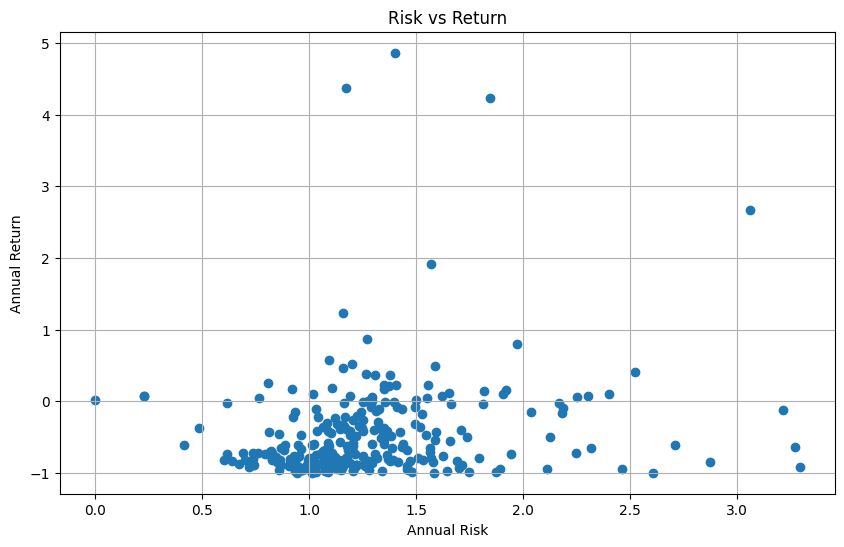

In [136]:
plt.figure(figsize=(10, 6))
plt.scatter(r_df['annual_risk'], r_df['annual_return'])
plt.xlabel('Annual Risk')
plt.ylabel('Annual Return')
plt.title('Risk vs Return')
plt.grid(True)
plt.show()

In [ ]:
# TODO write function to create figure

# TODO add portfolios of mostly NSDQ and then small crypto allocation: 1%, 10%, 20%, 30%, 40%


# -form the chart
# --annual return on y axis
# --annual risk on x axis
# --note in the figure BTC, ETH, and CMKT and SnP500 and NSDQ portfolio and ensure its easy to read off its risk and return
# --draw line thru rf and nsdq (if higher slope than SNP500) that is faint and dotted. 
# --draw line btwn risk free and cmkt that is solid. 

# -output the figure



In [ ]:
# TODO save figure to overleaf


In [ ]:
# TODO add commentary in overleaf
# -note that the figure is geom avg and sd so not quite sharpe but TS avg are way off for a vol asset over a short 260 obs
# -give the actual sharpes of BTC, ETH, CMKT, NSDQ, AND THEN THE RELEVANT CMKT+NSDQ portfolios for 2018-2022
# -discuss diff in slope as sharpe gain between NSDQ and crypto
# -discuss the gains from diversifications shown by the sharpe gain in the chart and give example of even trad port of 60/40 going to 59.5/39.5 and 1 or 55/35 and 10.
# -discuss how CMKT is not on eff frontier